In [1]:
# ---------------------------
# IMPORTS
# ---------------------------
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


2025-06-26 08:03:04.164257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750924984.370198      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750924984.430048      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# ---------------------------
# CONFIGURATION
# ---------------------------
IMG_SIZE = 224
BATCH_SIZE = 32
DATASET_DIR = '/kaggle/input/fer2013'
emotion_labels = ['disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'angry']
valid_extensions = ('.jpg', '.jpeg', '.png')

print("Using emotion labels:", emotion_labels)

Using emotion labels: ['disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'angry']


In [3]:
# ---------------------------
# MODEL DEFINITION
# ---------------------------
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(emotion_labels), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1750925000.742663      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 3,576,903 (13.64 MB)

 Trainable params: 1,318,919 (5.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [4]:
# ---------------------------
# LOAD & AUGMENT DATA
# ---------------------------
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    os.path.join(DATASET_DIR, "train"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    classes=emotion_labels
)

val_generator = datagen.flow_from_directory(
    os.path.join(DATASET_DIR, "train"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    classes=emotion_labels
)

test_generator = datagen.flow_from_directory(
    os.path.join(DATASET_DIR, "test"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    classes=emotion_labels
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
# ---------------------------
# TRAIN MODEL WITH CALLBACKS
# ---------------------------
EPOCHS = 25

# Define callbacks
checkpoint = ModelCheckpoint(
    'improved_best_emotion_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1750925024.505857      60 service.cc:148] XLA service 0x7ff78c1117a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750925024.506738      60 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750925025.548390      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/718 ━━━━━━━━━━━━━━━━━━━━ 2:48:30 14s/step - accuracy: 0.1562 - loss: 2.3950

I0000 00:00:1750925029.647929      60 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.3749 - loss: 1.7167
Epoch 1: val_accuracy improved from -inf to 0.42571, saving model to improved_best_emotion_model.h5
718/718 ━━━━━━━━━━━━━━━━━━━━ 178s 229ms/step - accuracy: 0.3750 - loss: 1.7165 - val_accuracy: 0.4257 - val_loss: 1.5107
Epoch 2/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4657 - loss: 1.3869
Epoch 2: val_accuracy improved from 0.42571 to 0.45950, saving model to improved_best_emotion_model.h5
718/718 ━━━━━━━━━━━━━━━━━━━━ 53s 74ms/step - accuracy: 0.4657 - loss: 1.3869 - val_accuracy: 0.4595 - val_loss: 1.4037
Epoch 3/25
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5000 - loss: 1.3177
Epoch 3: val_accuracy improved from 0.45950 to 0.47065, saving model to improved_best_emotion_model.h5
718/718 ━━━━━━━━━━━━━━━━━━━━ 51s 71ms/step - accuracy: 0.5000 - loss: 1.3177 - val_accuracy: 0.4706 - val_loss: 1.3814
Epoch 4/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5117 - loss: 1.27

In [6]:
# from tensorflow.keras.models import Model, load_model

# model = load_model("/kaggle/input/improved_best_emotion_model.h5/other/default/1/improved_best_emotion_model.h5")

225/225 ━━━━━━━━━━━━━━━━━━━━ 32s 144ms/step - accuracy: 0.4654 - loss: 1.4220
718/718 ━━━━━━━━━━━━━━━━━━━━ 44s 61ms/step - accuracy: 0.5907 - loss: 1.1003
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.4960 - loss: 1.3388
Training Accuracy: 0.5895
Validation Accuracy: 0.4898
Test Accuracy: 0.4925
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step


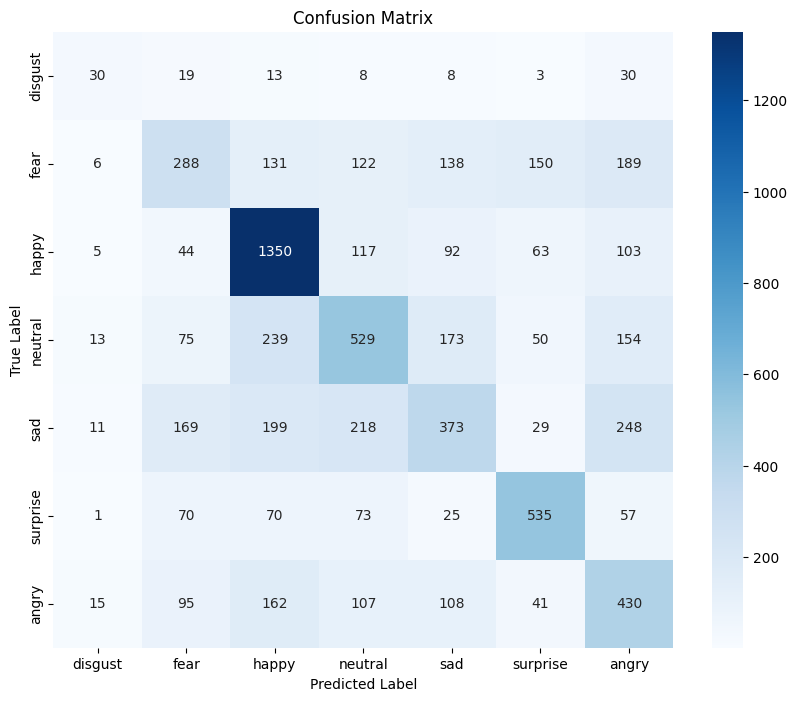


Classification Report:
              precision    recall  f1-score   support

     disgust       0.37      0.27      0.31       111
        fear       0.38      0.28      0.32      1024
       happy       0.62      0.76      0.69      1774
     neutral       0.45      0.43      0.44      1233
         sad       0.41      0.30      0.34      1247
    surprise       0.61      0.64      0.63       831
       angry       0.36      0.45      0.40       958

    accuracy                           0.49      7178
   macro avg       0.46      0.45      0.45      7178
weighted avg       0.48      0.49      0.48      7178



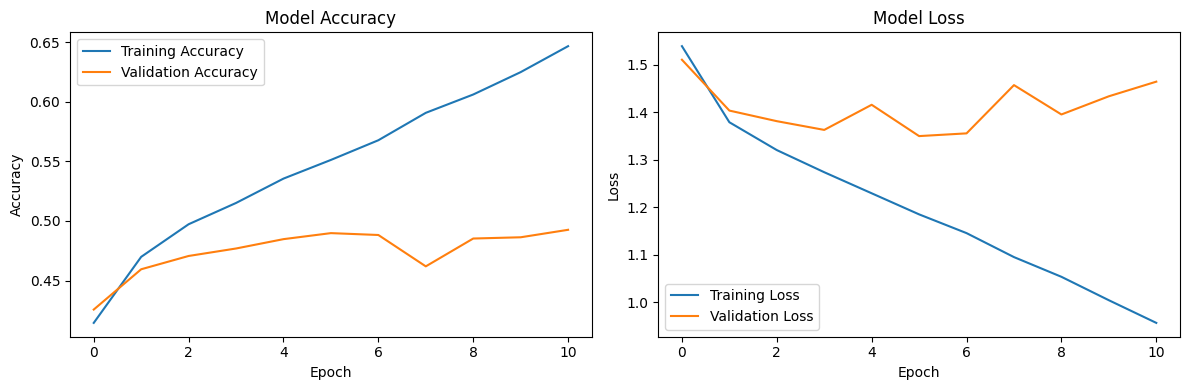

In [7]:
# ---------------------------
# EVALUATE MODEL & VISUALIZE RESULTS
# ---------------------------
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
train_loss, train_accuracy = model.evaluate(train_generator)
val_loss, val_accuracy = model.evaluate(val_generator)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions for confusion matrix
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=emotion_labels))

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [8]:
# ---------------------------
# GRAD-CAM HELPER FUNCTION
# ---------------------------
def get_gradcam_heatmap(img_array, model, class_index, layer_name='Conv_1'):
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-8)
    return heatmap.numpy()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


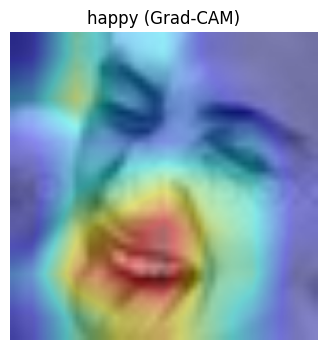

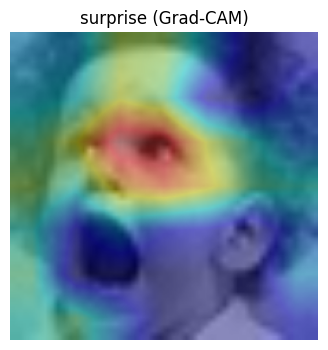

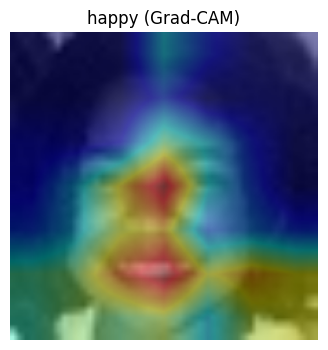

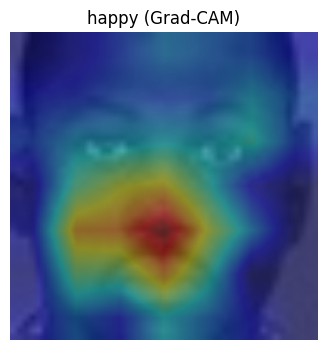

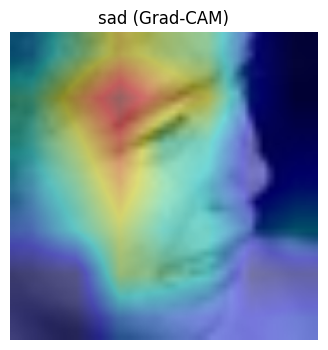

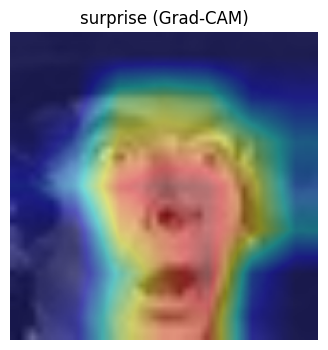

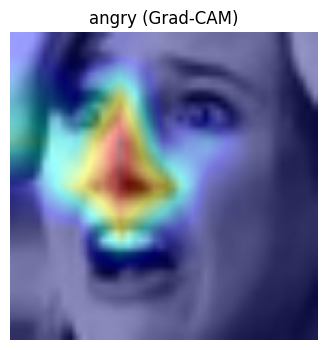

In [9]:
# ---------------------------
# PREDICT + GRAD-CAM
# ---------------------------
new_path = os.path.join(DATASET_DIR, "test")

for emotion_folder in emotion_labels:
    folder_path = os.path.join(new_path, emotion_folder)
    if not os.path.isdir(folder_path):
        continue

    image_list = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_extensions)]

    # Only process the first image in each class for Grad-CAM
    if image_list:
        img_name = image_list[0]
        img_path = os.path.join(folder_path, img_name)

        try:
            img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            preds = model.predict(img_array, verbose=0)[0]
            emotion_idx = np.argmax(preds)
            predicted_emotion = emotion_labels[emotion_idx]

            heatmap = get_gradcam_heatmap(img_array, model, emotion_idx)

            orig_img = cv2.imread(img_path)
            orig_img = cv2.resize(orig_img, (IMG_SIZE, IMG_SIZE))
            heatmap_resized = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))
            heatmap_resized = np.uint8(255 * heatmap_resized)
            heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
            superimposed_img = cv2.addWeighted(orig_img, 0.6, heatmap_color, 0.4, 0)

            # Show image
            plt.figure(figsize=(4, 4))
            plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
            plt.title(f"{predicted_emotion} (Grad-CAM)")
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"Error processing {img_path}: {e}")

In [ ]:
# ---------------------------
# WEBCAM EMOTION DETECTION
# ---------------------------
def webcam_emotion_detection(model, emotion_labels):
    cap = cv2.VideoCapture(0)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    emotion_log = []
    emotion_counts = {label: 0 for label in emotion_labels}

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        for (x, y, w, h) in faces:
            face = frame[y:y+h, x:x+w]
            face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
            face_array = img_to_array(face) / 255.0
            face_array = np.expand_dims(face_array, axis=0)

            preds = model.predict(face_array, verbose=0)[0]
            emotion_idx = np.argmax(preds)
            predicted_emotion = emotion_labels[emotion_idx]
            confidence = preds[emotion_idx]

            # Log emotion
            emotion_log.append({
                'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                'emotion': predicted_emotion,
                'confidence': float(confidence)
            })
            emotion_counts[predicted_emotion] += 1

            # Draw bounding box and label
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            label = f'{predicted_emotion}: {confidence:.2f}'
            cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        cv2.imshow('Emotion Detection', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    # Save emotion log
    pd.DataFrame(emotion_log).to_csv('webcam_emotion_log.csv', index=False)

    # Plot emotion distribution
    plt.figure(figsize=(10, 6))
    plt.bar(emotion_counts.keys(), emotion_counts.values())
    plt.title('Webcam Emotion Detection Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('webcam_emotion_distribution.png')
    plt.show()

# Run webcam detection
webcam_emotion_detection(model, emotion_labels)